In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import joblib
from coclust.coclustering import CoclustInfo, CoclustMod
from ampute import ampute_mar, ampute_mcar
from utils import (show_matrix, _impute_block_representative, RMSE)
from colust_info_impute import CoclustInfoImpute

from sklearn.metrics.cluster import normalized_mutual_info_score as NMI

import warnings
warnings.filterwarnings("ignore")

In [118]:
X = np.array([
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1],
    [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0],
    [1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0]])

X_ampute, na_rows, na_cols = ampute_mcar(X)
X_ampute

array([[ 0.,  0.,  0.,  0., nan,  0.,  0.,  1.,  0., nan,  1., nan, nan,
         0.,  0.,  0.],
       [ 0.,  1., nan, nan,  0.,  0.,  1.,  0.,  0.,  0.,  0., nan,  0.,
         0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,
        nan,  0.,  0.],
       [ 1.,  0.,  0., nan,  1.,  1.,  0., nan, nan,  1.,  0.,  0.,  1.,
         1.,  0.,  1.],
       [nan, nan, nan,  1.,  0., nan,  1.,  0.,  0., nan,  0.,  1.,  0.,
         0., nan,  0.],
       [ 1.,  0., nan,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,
         1., nan,  1.],
       [ 0., nan,  0.,  0., nan,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,
         1., nan,  0.],
       [ 0., nan,  0.,  0.,  0., nan,  0., nan,  0.,  0.,  1.,  0.,  0.,
        nan,  0.,  0.],
       [ 0.,  1.,  1.,  1., nan, nan,  1.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  1.,  0.]])

In [115]:
dd = CoclustInfoImpute(n_row_clusters=3,n_col_clusters=3)
dd.fit(X_ampute,impute_func=_impute_block_representative)

/Users/money/Desktop/Projet_Innovation/colust_info_impute.py:89: FutureWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  warn_on_dtype=False, estimator=None)
/usr/local/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


CoclustInfoImpute(init=None, max_iter=20, n_col_clusters=3, n_init=1,
                  n_row_clusters=3, random_state=None, tol=1e-09)

In [14]:
dd.X_.toarray()

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.84862558e-34, 0.00000000e+00, 0.00000000e+00, 2.77777778e-02,
        0.00000000e+00, 5.20833333e-03, 2.77777778e-02, 5.20833333e-03,
        5.20833333e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.77777778e-02, 1.84862558e-34, 5.20833333e-03,
        0.00000000e+00, 0.00000000e+00, 2.77777778e-02, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.20833333e-03,
        0.00000000e+00, 0.00000000e+00, 2.77777778e-02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.77777778e-02,
        0.00000000e+00, 0.00000000e+00, 2.77777778e-02, 0.00000000e+00,
        0.00000000e+00, 5.20833333e-03, 0.00000000e+00, 0.00000000e+00],
       [2.77777778e-02, 0.00000000e+00, 0.00000000e+00, 1.45502646e-02,
        2.77777778e-02, 2.77777778e-02, 0.00000000e+00, 3.472

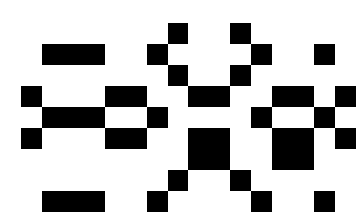

In [15]:
show_matrix(X)

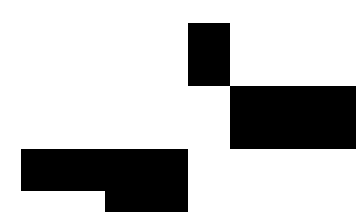

In [16]:
temp = X[np.ix_([0, 2, 7, 1, 4, 8, 3, 5, 6],
             [ 0,  4,  5, 15,  8,  9, 12, 13,  7, 10,  1,  2,  3,  6, 11, 14])]
show_matrix(temp)

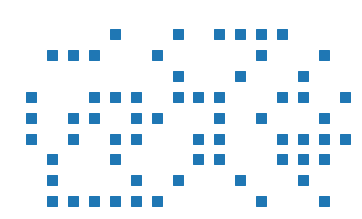

In [23]:
show_matrix(dd.X_)

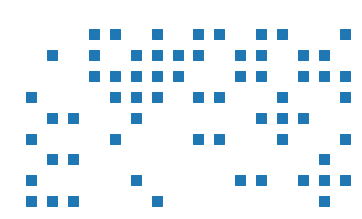

In [24]:
show_matrix(dd.X_[np.ix_(np.argsort(dd.row_labels_),np.argsort(dd.column_labels_))])

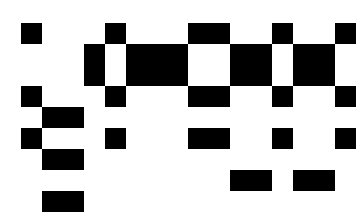

In [17]:
temp1 = X[np.ix_(np.argsort(dd.row_labels_),np.argsort(dd.column_labels_))]
show_matrix(temp1)

In [22]:
dd.row_labels_

[2, 2, 2, 1, 0, 1, 2, 2, 1]

In [20]:
np.argsort(dd.row_labels_)

array([4, 3, 5, 8, 0, 1, 2, 6, 7])

In [21]:
np.argsort(dd.column_labels_)

array([ 1,  7, 10,  0,  2,  4,  5, 15,  3,  6,  8,  9, 11, 12, 13, 14])

In [30]:
NMI([0, 2, 7, 1, 4, 8, 3, 5, 6], dd.row_labels_)

0.5978650686516749

In [31]:
NMI([ 0,  4,  5, 15,  8,  9, 12, 13,  7, 10,  1,  2,  3,  6, 11, 14], dd.column_labels_)

0.5394042270255305

In [41]:
temp = sio.loadmat('../cluto/cstr.mat')
cstr = temp["fea"]
cstr_class = temp['gnd'].reshape(1,-1)[0]

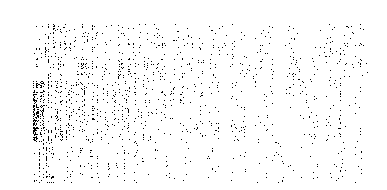

In [44]:
show_matrix(cstr)

In [48]:
X,na_rows, na_cols = ampute_mcar(cstr,prop=0.5)

In [52]:
cstr_model = CoclustInfoImpute(n_row_clusters=4,n_col_clusters=4)
cstr_model.fit(X,impute_func=_impute_block_representative,na_rows=na_rows,na_cols=na_cols)

/Users/money/Desktop/Projet_Innovation/colust_info_impute.py:89: FutureWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  warn_on_dtype=False, estimator=None)
/usr/local/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


CoclustInfoImpute(init=None, max_iter=20, n_col_clusters=4, n_init=1,
                  n_row_clusters=4, random_state=None, tol=1e-09)

/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:7717: RuntimeWarning: invalid value encountered in greater
  mask = np.abs(Z) > precision


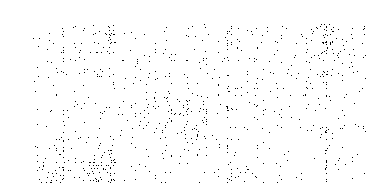

In [54]:
show_matrix(X[np.ix_(np.argsort(cstr_model.row_labels_),np.argsort(cstr_model.column_labels_))])

In [55]:
NMI(cstr_class, cstr_model.row_labels_)

0.0337560986777109

In [56]:
X,na_rows, na_cols = ampute_mcar(cstr,prop=0.2)

In [57]:
cstr_model = CoclustInfoImpute(n_row_clusters=4,n_col_clusters=4)
cstr_model.fit(X,impute_func=_impute_block_representative,na_rows=na_rows,na_cols=na_cols)

/Users/money/Desktop/Projet_Innovation/colust_info_impute.py:89: FutureWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  warn_on_dtype=False, estimator=None)
/usr/local/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


CoclustInfoImpute(init=None, max_iter=20, n_col_clusters=4, n_init=1,
                  n_row_clusters=4, random_state=None, tol=1e-09)

In [58]:
NMI(cstr_class, cstr_model.row_labels_)

0.09020819555500945

In [59]:
X,na_rows, na_cols = ampute_mcar(cstr,prop=0.05)

In [60]:
cstr_model = CoclustInfoImpute(n_row_clusters=4,n_col_clusters=4)
cstr_model.fit(X,impute_func=_impute_block_representative,na_rows=na_rows,na_cols=na_cols)

/Users/money/Desktop/Projet_Innovation/colust_info_impute.py:89: FutureWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  warn_on_dtype=False, estimator=None)
/usr/local/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


CoclustInfoImpute(init=None, max_iter=20, n_col_clusters=4, n_init=1,
                  n_row_clusters=4, random_state=None, tol=1e-09)

In [61]:
NMI(cstr_class, cstr_model.row_labels_)

0.49835457740008404

### Load required data

In [2]:
temp = sio.loadmat('./data/complete_data/cstr.mat')
cstr_lab = temp['gnd'].reshape(1,-1)[0]
cstr_data = temp['fea']

In [38]:
temp = sio.loadmat('./data/complete_data/webAce.mat')
webace_lab = temp['gnd'].reshape(1,-1)[0]
webace_data = temp['fea']

In [46]:
temp = sio.loadmat('./data/complete_data/reviews.mat')
reviews_lab = temp['classid'].reshape(1,-1)[0]
reviews_data = temp['dtm'].toarray()

In [3]:
temp = sio.loadmat('./data/complete_data/classic3.mat')
classic3_lab = temp['labels'].reshape(1,-1)[0]
classic3_data = temp['A'].toarray()

In [4]:
temp = sio.loadmat('./data/complete_data/classic4.mat')
classic4_lab = temp['labels'][0]
classic4_data = temp['mat'].toarray()

In [60]:
def set_nan(data, r_nan, c_nan):
    X = data.copy()
    X = X.astype(float)
    X[r_nan, c_nan] = np.nan
    return X

def load_index(name, prob):
    index = joblib.load(f'./mar_missing_data/nan_idx-{name}-mar-{prob}.joblib')
    return index['r_nan'], index['c_nan']
    

def execute_coclust_info_impute(datasets,probs=[0.1, 0.2, 0.5,0.7],impute_fn=None):
    
    for prob in probs:
        for key,value in datasets.items():
            r_nan, c_nan = load_index(key,prob)
            temp_data = set_nan(value[0], r_nan, c_nan)
            n_clusters = len(np.unique(value[1]))
            model = CoclustInfoImpute(n_row_clusters=n_clusters,n_col_clusters=n_clusters)
            model.fit(temp_data,impute_func=impute_fn,na_rows=r_nan,na_cols=c_nan)
            nmi = NMI(value[1], model.row_labels_)
            joblib.dump({'model': model, 'nmi': nmi}, f'./output/impute_coclust_info_result_{key}_{prob}.joblib')
    return 

def replace_imputed_ca(data,name,prob):
    X = data.copy()
    temp = joblib.load(f'./data/impute_data/{name}_{prob}%_mcar.joblib')
    imputed = temp['imputed']
    r_nan = temp['r_nan']
    c_nan = temp['c_nan']
    X[r_nan,c_nan] = imputed
    return X
    

def excecute_coclust_info_impute_ca(datasets,probs=[0.1, 0.2, 0.5,0.7]):
    
    for prob in probs:
        for key, value in datasets.items():
            temp_data = replace_imputed_ca(value[0], key, int(100 * prob))
            n_clusters = len(np.unique(value[1]))
            model = CoclustInfo(n_row_clusters=n_clusters,n_col_clusters=n_clusters)
            model.fit(temp_data)
            nmi = NMI(value[1], model.row_labels_)
            joblib.dump({'model': model, 'nmi': nmi}, f'./output/impute_ca_cocluct_info_result_{key}_{prob}.joblib')
    return

In [61]:
datasets = {'cstr': [cstr_data, cstr_lab],'webace': [webace_data, webace_lab], 'reviews': [reviews_data, reviews_lab],
           'classic3': [classic3_data, classic3_lab], 'classic4': [classic4_data, classic4_lab]}
execute_coclust_info_impute(datasets, impute_fn=_impute_block_representative)

In [ ]:
excecute_coclust_info_impute_ca(datasets)

In [43]:
temp['dtm'].shape

(4069, 18483)

In [16]:
temp['mat'].toarray()

array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
np.sum(np.isnan(temp['mat'].toarray()))

0

In [22]:
temp = joblib.load('./data/impute_data/cstr_10%_mcar.joblib')

In [23]:
temp

{'imputed': array([0.88060116, 0.07709015, 5.45043553, ..., 0.2426331 , 1.52377471,
        0.11756154]),
 'real': array([0., 0., 0., ..., 0., 0., 0.]),
 'r_nan': array([ 18, 461, 334, ..., 421, 370, 272]),
 'c_nan': array([298, 739, 277, ..., 462, 972, 854])}

In [24]:
temp['imputed']

array([0.88060116, 0.07709015, 5.45043553, ..., 0.2426331 , 1.52377471,
       0.11756154])

In [25]:
len(temp['imputed'])

47500

In [30]:
dd = np.array([[1,2,3],[2,3,4],[4,5,6]])

In [31]:
dd

array([[1, 2, 3],
       [2, 3, 4],
       [4, 5, 6]])

In [32]:
dd[[0,2],[1,2]] = [4,10]

In [33]:
dd

array([[ 1,  4,  3],
       [ 2,  3,  4],
       [ 4,  5, 10]])